## Did "Yuri on Ice" spark a national interest in ice skating?

Examining the impact of the sports anime _Yuri on Ice_ on national interest levels on ice skating. The original run of the anime lasted from October 6, 2016 – December 21, 2016.

MODELLING TO DO:
- Clean up code so I can easily run by country, or globally
- Get results for globally, and every country, and save to pickle files
- Quantify errors before and after to show effect of Yuri
- Add yuri_interest_level as a feature, and see how that impacts the model
- Decomposition https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

VISUALISATION TO DO:
- Graphs
- Tableau

### Libraries and Setup
Install required libraries including:
- pytrends API (the unofficial API for GoogleTrends)

Source: https://towardsdatascience.com/google-trends-api-for-python-a84bc25db88f

##### Install libraries

In [32]:
# !pip install pytrends
# !pip install seaborn
# !pip install pycountry
# !pip install xgboost
# !pip install sklearn
# !pip install scikit-learn
# !pip install bs4

##### Import libraries

In [1]:
# General
import os.path

# Analytics
import pandas as pd    
import numpy as np     

# Reimport a module while interative
import importlib

# GoogleTrends API
from pytrends.request import TrendReq

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Getting country codes
import pycountry

# Get the last day of the month from a given date
import calendar
from datetime import datetime

# Warning control
import warnings
warnings.filterwarnings("ignore")

print("Import libraries successful!")

Import libraries successful!


##### Import local libraries

In [2]:
# Reimport modules if needed
import pythonlib.gtrends as gtrends
importlib.reload(gtrends)

import pythonlib.date_helper as date_helper
importlib.reload(date_helper)

import pythonlib.data_scraper as data_scraper
importlib.reload(data_scraper)

import pythonlib.etl_helper as etl_helper
importlib.reload(etl_helper)


print("Reimport of local libraries successful!")

Reimport of local libraries successful!


In [3]:
from pythonlib.gtrends import getInterestOverTime, getMonthlyInterest
from pythonlib.date_helper import getYears, getLastDay, getDates, getDateFeatures, getPastInterest
from pythonlib.data_scraper import scrapeWinterOlympics, getWinterOlympics
from pythonlib.etl_helper import cleanTrainingDataset, cleanPredictionDataset

print("Import local libraries successful!")

Import local libraries successful!


#### Set parameters

In [4]:
# Set parameters
parameters = {
    "debug" : True,                         # Whether to print out additional information
    "timeframe" : '2004-01-01 2023-07-01'   # Date range of data
}

# Print out parameters nicely
print("Parameters:")
print("----------------")
for parameter, value in parameters.items():
    print("{} : {}".format(parameter, value))
print("----------------")

Parameters:
----------------
debug : True
timeframe : 2004-01-01 2023-07-01
----------------


### Extract data

**1) Google Trends**

World aggregates
1. Aggregate world interest for _Yuri on Ice_
2. Aggregate world interest for _ice skating_

Breakdown by country
1. Country-level interest for _Yuri on Ice_
2. Country-level interest for _ice skating_

**2) Winter Olympics Dates**

**3) Validation against GoogleTrends webpage**

#### World aggregates - _Yuri on Ice_

Monthly data
- Check if the file specified by "path" exists, and if it does, take that
- If the file does not exist, we call the Google Trends API to extract data and save it into the path

In [5]:
# Set parameters
path = "./data/yuri_world_df.pkl"
search_term_lst = ["Yuri on Ice"]
topic_name = "Japanese animated series"
timeframe = parameters["timeframe"]
# Get monthly interest data
yuri_world_df = getMonthlyInterest(path, search_term_lst, topic_name, refresh_data=False, timeframe=timeframe)
# Rename columns
yuri_world_df.rename(columns={"interest_level":"yuri_interest_level"}, inplace=True)

# Display if debugging
if parameters["debug"]:
    print("yuri_world_df:")
    display(yuri_world_df)


Taking existing file  ./data/yuri_world_df.pkl
yuri_world_df:


,date,yuri_interest_level,isPartial
0,2004-01-01,0,False
1,2004-02-01,0,False
2,2004-03-01,0,False
3,2004-04-01,0,False
4,2004-05-01,0,False
...,...,...,...
230,2023-03-01,2,False
231,2023-04-01,2,False
232,2023-05-01,2,False
233,2023-06-01,2,False


#### World aggregates - _Ice skating_
Monthly data
- Check if the file specified by "path" exists, and if it does, take that
- If the file does not exist, we call the Google Trends API to extract data and save it into the path

In [6]:
# Set parameters
path = "./data/ice_world_df.pkl"
search_term_lst = ["Ice skating"]
topic_name = "Sports"
timeframe = parameters["timeframe"]
# Get monthly interest data
ice_world_df = getMonthlyInterest(path, search_term_lst, topic_name, refresh_data=False, timeframe=timeframe)
# Rename columns
ice_world_df.rename(columns={"interest_level":"ice_interest_level"}, inplace=True)

# Display if debugging
if parameters["debug"]:
    print("ice_world_df:")
    display(ice_world_df)

Taking existing file  ./data/ice_world_df.pkl
ice_world_df:


,date,ice_interest_level,isPartial
0,2004-01-01,40,False
1,2004-02-01,29,False
2,2004-03-01,26,False
3,2004-04-01,18,False
4,2004-05-01,16,False
...,...,...,...
230,2023-03-01,13,False
231,2023-04-01,9,False
232,2023-05-01,7,False
233,2023-06-01,7,False


#### Breakdown by country - _Ice Skating_

In [7]:
# Get list of all 2-letter country codes
country_lst = list(pycountry.countries)
country_code_lst = [country.alpha_2 for country in country_lst]
country_name_lst = [country.name for country in country_lst]

# Country dataframe
country_df = pd.DataFrame()
country_df['country_code'] = country_code_lst
country_df['name'] = country_name_lst

In [8]:
country_df[country_df['name']=="Japan"]

,country_code,name
115,JP,Japan


Get Japan's Ice Skating interest level

In [9]:
path = "./data/ice_jp_df.pkl"
geo = "JP"

if os.path.isfile(path):
    print("Taking existing file ", path)
    ice_jp_df = pd.DataFrame()
    ice_jp_df = pd.read_pickle(path)
else:
    print("Getting interest over time for Ice Skating...")
    ice_topic_id, ice_jp_df = getInterestOverTime(["Ice skating"], "Sports", geo=geo)
    # Save to pickle file
    print("Saving data into ", path)
    ice_jp_df.to_pickle(path)

Taking existing file  ./data/ice_jp_df.pkl


In [10]:
ice_jp_df.rename(columns={"interest_level":"ice_interest_level"}, inplace=True)
# Get list of years
ice_years_lst = getYears(ice_jp_df)

#### Winter Olympics Dates
- Check if the file specified by "path" exists, and if it does, take that
- If the file does not exist, we call webscrape Wikipedia to extract data and save it into the path

In [11]:
# Set parameters
path = "./data/winter_olympics.pkl"
url = "https://en.wikipedia.org/wiki/Winter_Olympic_Games#List_of_Winter_Olympic_Games"
# Get Winter Olympics data
winter_olympics_df = getWinterOlympics(path, refresh_data=False, url=url)

Taking existing file  ./data/winter_olympics.pkl


### Predicting Ice Skating Interest Level

We want to predict the interest level for ice skating for all time periods **before** the _Yuri on Ice_ anime series premiered. That is, for all months _before_ October 2016. 

#### World Trend

Create date features

In [12]:
# Create date features
ice_world_df = getDateFeatures(ice_world_df)

# Display if debugging
if parameters["debug"]:
    print("Created date features...")
    print("ice_world_df:")
    display(ice_world_df)

Created date features...
ice_world_df:


,date,ice_interest_level,isPartial,year,month
0,2004-01-01,40,False,2004,1
1,2004-02-01,29,False,2004,2
2,2004-03-01,26,False,2004,3
3,2004-04-01,18,False,2004,4
4,2004-05-01,16,False,2004,5
...,...,...,...,...,...
230,2023-03-01,13,False,2023,3
231,2023-04-01,9,False,2023,4
232,2023-05-01,7,False,2023,5
233,2023-06-01,7,False,2023,6


Add in Winter Olympics features

In [13]:
# Merge Winter Olympics data into dataframe to create features
ice_world_df = pd.merge(ice_world_df, winter_olympics_df, how="left", on="year")
# Check if a month has the Winter Olympics if it corresponds to the start or end month of the Olympics
ice_world_df['is_winter_olympics'] = np.where((ice_world_df['month'] == ice_world_df['start_month']) |
                                              (ice_world_df['month'] == ice_world_df['end_month']), True, False)

# Display if debugging
if parameters["debug"]:
    print("Added in Winter Olympics features...")
    print("Displaying rows where there is Winter Olympics - ice_world_df:")
    display(ice_world_df[ice_world_df['is_winter_olympics'] == True])

Added in Winter Olympics features...
Displaying rows where there is Winter Olympics - ice_world_df:


,date,ice_interest_level,isPartial,year,month,date_pairs,start_day,end_day,start_month,end_month,is_winter_olympics
25,2006-02-01,86,False,2006,2,"[10, 26]",10.0,26.0,2.0,2.0,True
73,2010-02-01,75,False,2010,2,"[12, 28]",12.0,28.0,2.0,2.0,True
121,2014-02-01,82,False,2014,2,"[7, 23]",7.0,23.0,2.0,2.0,True
169,2018-02-01,100,False,2018,2,"[9, 25]",9.0,25.0,2.0,2.0,True
217,2022-02-01,55,False,2022,2,"[4, 20]",4.0,20.0,2.0,2.0,True


Get historical data feature
- Get the ice_interest_level for the same month in the previous year

In [14]:
# Get historical interest
ice_world_join_df = getPastInterest(ice_world_df, "ice_interest_level", "ice_historical_interest")
# Replace dataframe with new dataframe
ice_world_df = ice_world_join_df
# Clean up dataframe
ice_world_df = ice_world_df.drop(columns=['date_pairs', 'start_day', 'end_day', 'start_month', 'end_month', 
                                          'year_hist', 'month_match', 'year_match', '_merge'])
ice_world_df['ice_historical_interest'] = ice_world_df['ice_historical_interest'].astype('int') 

# Display if debugging
if parameters["debug"]:
    print("Added in historical interest levels...")
    print(ice_world_df.dtypes)
    print("ice_world_df:")
    display(ice_world_df)

Added in historical interest levels...
date                       datetime64[ns]
ice_interest_level                  int32
isPartial                            bool
year                                int32
month                               int32
is_winter_olympics                   bool
ice_historical_interest             int32
dtype: object
ice_world_df:


,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest
0,2004-01-01,40,False,2004,1,False,40
1,2004-02-01,29,False,2004,2,False,29
2,2004-03-01,26,False,2004,3,False,26
3,2004-04-01,18,False,2004,4,False,18
4,2004-05-01,16,False,2004,5,False,16
...,...,...,...,...,...,...,...
230,2023-03-01,13,False,2023,3,False,15
231,2023-04-01,9,False,2023,4,False,9
232,2023-05-01,7,False,2023,5,False,8
233,2023-06-01,7,False,2023,6,False,8


Clean dataset

In [15]:
# Clean dataset
ice_world_clean_df = cleanTrainingDataset(ice_world_df)

# Display if debugging
if parameters["debug"]:
    print("Cleaned dataset...")
    print("ice_world_df rows:", len(ice_world_df))
    print("ice_world_clean_df rows:", len(ice_world_clean_df))
    display(ice_world_clean_df.sample(5))

Cleaned dataset...
ice_world_df rows: 235
ice_world_clean_df rows: 153


,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest
101,2012-06-01,10,False,2012,6,False,10
89,2011-06-01,10,False,2011,6,False,10
13,2005-02-01,28,False,2005,2,False,29
119,2013-12-01,36,False,2013,12,False,34
124,2014-05-01,9,False,2014,5,False,8


Build an XGBoost DMatrix

In [16]:
def buildDMatrix(trend_df, x_cols, y_cols, cat_cols, random_state=1, test_size=0.25, enable_categorical=True):
    # Extract feature and target arrays
    print("Extracting feature and target arrays...")
    X = trend_df[x_cols] # Feature array
    y = trend_df[y_cols] # Target array i.e., what to predict for
    print("Done!\n", "---")

    # Cast categorical features as category object
    # Extract text features
    print("Casting categorical features as category object...")
    cats = cat_cols

    # Convert to Pandas category
    for col in cats:
        X[col] = X[col].astype('category')

    print(X.dtypes)
    print("Done!\n", "---")

    # Split the data
    print("Splitting the data into train and test...")
    # If we want everything to be in training or everything to be in testing
    if test_size == 0 or test_size == 1.0:
        # Set training and testing both to equal X and y
        X_train = X
        y_train = y
        # Set test to empty dataframes
        X_test = X
        y_test = y
        # print warning
        print("Warning: you set test_size = ", test_size, 
              ". Setting X_train, X_test = X and y_train, y_test = y.")
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print("Done!\n", "---")

    # Convert to DMatrix class because it is a highly optimized class for memory and speed
    # Create regression matrices
    print("Creating DMatrix regression matrices...")
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
    print("Done!")
    
    return X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg


In [17]:
def getPredictions(model, dtest_reg, y_test, squared=False):
    preds = model.predict(dtest_reg)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"RMSE of the base model: {rmse:.3f}")

    return preds, rmse

In [18]:
def getEvaluationMetrics(y, preds, eval_cols, x_cols, target_col):
    # Create an dataframe eval_df with evaluation metrics
    eval_df = y
    eval_df['preds'] = preds

    # Put columns into eval_df from X
    eval_df[eval_cols] = X[x_cols]

    # Get % difference between target values and predicted values
    eval_df['diff'] = eval_df[target_col] - eval_df['preds']
    eval_df['diff_perc'] = eval_df['diff'] / eval_df['ice_interest_level']

    return eval_df

In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

x_cols = ['year', 'month', 'is_winter_olympics']
y_cols = ['ice_interest_level']
cat_cols = ['year', 'month', 'is_winter_olympics']
random_state = 1

X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg = buildDMatrix(ice_world_clean_df, 
                                                                             x_cols, y_cols, cat_cols, random_state)

Extracting feature and target arrays...
Done!
 ---
Casting categorical features as category object...
year                  category
month                 category
is_winter_olympics    category
dtype: object
Done!
 ---
Splitting the data into train and test...
Done!
 ---
Creating DMatrix regression matrices...
Done!


Train model

In [20]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}
n = 100

# Train model
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

Evaluate model

In [21]:
# Evaluation
from sklearn.metrics import mean_squared_error
preds, rmse = getPredictions(model, dtest_reg, y_test, False)

RMSE of the base model: 2.633


In [22]:
# Get evaluation metrics dataframe
eval_cols = ['year', 'month']
x_cols = ['year', 'month']
target_col = 'ice_interest_level'
eval_df = getEvaluationMetrics(y_test, preds, eval_cols, x_cols, target_col)

eval_df

,ice_interest_level,preds,year,month,diff,diff_perc
59,42,40.745712,2008,12,1.254288,0.029864
33,21,20.216883,2006,10,0.783117,0.037291
69,17,13.842012,2009,10,3.157988,0.185764
127,10,9.975791,2014,8,0.024209,0.002421
31,15,17.338341,2006,8,-2.338341,-0.155889
107,34,36.393185,2012,12,-2.393185,-0.070388
97,34,21.079687,2012,2,12.920313,0.380009
14,25,24.812437,2005,3,0.187563,0.007503
53,11,11.802571,2008,6,-0.802571,-0.072961
44,15,16.628626,2007,9,-1.628626,-0.108575


Plot the predictions

In [23]:
result = pd.merge(ice_world_df, eval_df[['year', 'month', 'preds']], how='left', on=['year', 'month'])
result

,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest,preds
0,2004-01-01,40,False,2004,1,False,40,NaN
1,2004-02-01,29,False,2004,2,False,29,NaN
2,2004-03-01,26,False,2004,3,False,26,NaN
3,2004-04-01,18,False,2004,4,False,18,NaN
4,2004-05-01,16,False,2004,5,False,16,NaN
...,...,...,...,...,...,...,...,...
230,2023-03-01,13,False,2023,3,False,15,NaN
231,2023-04-01,9,False,2023,4,False,9,NaN
232,2023-05-01,7,False,2023,5,False,8,NaN
233,2023-06-01,7,False,2023,6,False,8,NaN


<Axes: xlabel='date'>

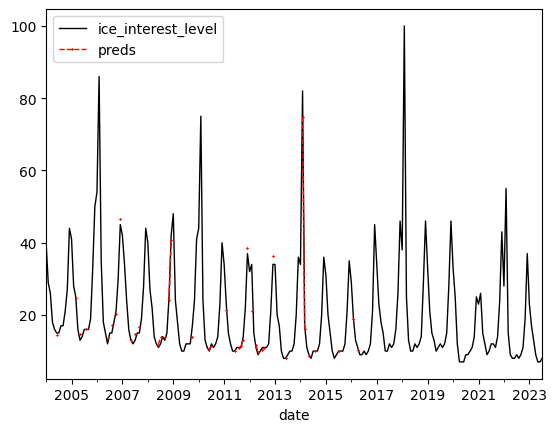

In [24]:
# line plot
fig, ax = plt.subplots()

result.plot.line(ax=ax, x = 'date', y = 'ice_interest_level', color = 'black', linewidth = 1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'preds', color = 'r', linewidth = 1,  marker = 'x', ms=1, linestyle ='dashed')

Get predictions for all the dates

In [25]:
# Create matrix for all
dpred_reg = xgb.DMatrix(X, y, enable_categorical=True)

In [26]:
# Get predictions
preds, rmse = getPredictions(model, dpred_reg, y, False)

RMSE of the base model: 1.329


In [27]:
# Get evaluation metrics dataframe
eval_cols = ['year', 'month']
x_cols = ['year', 'month']
target_col = 'ice_interest_level'
eval_df = getEvaluationMetrics(y, preds, eval_cols, x_cols, target_col)

eval_df

,ice_interest_level,preds,year,month,diff,diff_perc
0,40,39.999146,2004,1,0.000854,0.000021
1,29,29.002289,2004,2,-0.002289,-0.000079
2,26,25.994213,2004,3,0.005787,0.000223
3,18,17.985975,2004,4,0.014025,0.000779
4,16,16.002851,2004,5,-0.002851,-0.000178
...,...,...,...,...,...,...
148,9,8.989907,2016,5,0.010093,0.001121
149,9,9.001842,2016,6,-0.001842,-0.000205
150,10,9.999834,2016,7,0.000166,0.000017
151,9,9.012845,2016,8,-0.012845,-0.001427


Plot predictions for all dates

In [28]:
result = pd.merge(ice_world_df, eval_df[['year', 'month', 'preds']], how='left', on=['year', 'month'])
result

,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest,preds
0,2004-01-01,40,False,2004,1,False,40,39.999146
1,2004-02-01,29,False,2004,2,False,29,29.002289
2,2004-03-01,26,False,2004,3,False,26,25.994213
3,2004-04-01,18,False,2004,4,False,18,17.985975
4,2004-05-01,16,False,2004,5,False,16,16.002851
...,...,...,...,...,...,...,...,...
230,2023-03-01,13,False,2023,3,False,15,NaN
231,2023-04-01,9,False,2023,4,False,9,NaN
232,2023-05-01,7,False,2023,5,False,8,NaN
233,2023-06-01,7,False,2023,6,False,8,NaN


<Axes: xlabel='date'>

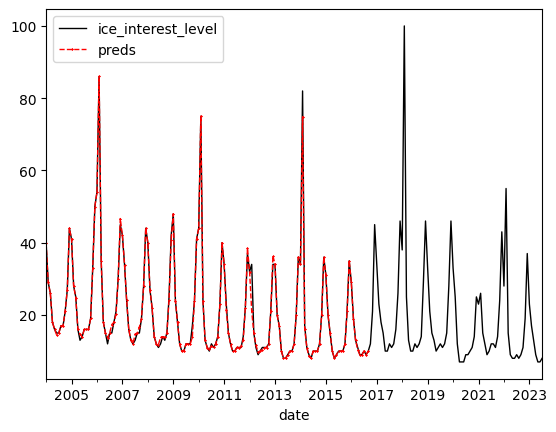

In [29]:
# line plot
fig, ax = plt.subplots()

result.plot.line(ax=ax, x = 'date', y = 'ice_interest_level', color = 'black', linewidth = 1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'preds', color = 'r', linewidth = 1,  marker = 'x', ms=1, linestyle ='dashed')

Get predictions after Yuri aired

In [30]:
# Get prediction dataset to predict for interest levels without Yuri on Ice
ice_world_prediction_df = cleanPredictionDataset(ice_world_df)
# Print some details of cleaned dataset
print("ice_world_df rows:", len(ice_world_df))
print("ice_world_prediction_df rows:", len(ice_world_prediction_df))
ice_world_prediction_df.sample(5)

ice_world_df rows: 235
ice_world_prediction_df rows: 234


,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest
121,2014-02-01,82,False,2014,2,True,20
203,2020-12-01,25,False,2020,12,False,46
104,2012-09-01,11,False,2012,9,False,11
227,2022-12-01,37,False,2022,12,False,43
177,2018-10-01,14,False,2018,10,False,16


In [31]:
# Build DMatrix
x_cols = ['year', 'month', 'is_winter_olympics']
y_cols = ['ice_interest_level']
cat_cols = ['year', 'month', 'is_winter_olympics']
random_state = 1
test_size = 1.0

X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg = buildDMatrix(ice_world_prediction_df, 
                                                                             x_cols, y_cols, cat_cols, random_state,
                                                                             test_size)

Extracting feature and target arrays...
Done!
 ---
Casting categorical features as category object...
year                  category
month                 category
is_winter_olympics    category
dtype: object
Done!
 ---
Splitting the data into train and test...
Done!
 ---
Creating DMatrix regression matrices...
Done!


In [32]:
# Get predictions
preds, rmse = getPredictions(model, dtest_reg, y_test, False)

RMSE of the base model: 3.479


In [33]:
eval_cols = ['year', 'month']
x_cols = ['year', 'month']
target_col = 'ice_interest_level'
eval_df = getEvaluationMetrics(y, preds, eval_cols, x_cols, target_col)

eval_df

,ice_interest_level,preds,year,month,diff,diff_perc
0,40,39.999146,2004,1,0.000854,0.000021
1,29,29.002289,2004,2,-0.002289,-0.000079
2,26,25.994213,2004,3,0.005787,0.000223
3,18,17.985975,2004,4,0.014025,0.000779
4,16,16.002851,2004,5,-0.002851,-0.000178
...,...,...,...,...,...,...
229,17,18.792860,2023,2,-1.792860,-0.105462
230,13,13.010624,2023,3,-0.010624,-0.000817
231,9,10.420856,2023,4,-1.420856,-0.157873
232,7,8.989907,2023,5,-1.989907,-0.284272


Plot predictions for all dates

In [34]:
result = pd.merge(ice_world_df, eval_df[['year', 'month', 'preds']], how='left', on=['year', 'month'])
# Merge with Yuri on Ice
result = pd.merge(result, yuri_world_df[['date', 'yuri_interest_level']], how='left', on=['date'])
result

,date,ice_interest_level,isPartial,year,month,is_winter_olympics,ice_historical_interest,preds,yuri_interest_level
0,2004-01-01,40,False,2004,1,False,40,39.999146,0
1,2004-02-01,29,False,2004,2,False,29,29.002289,0
2,2004-03-01,26,False,2004,3,False,26,25.994213,0
3,2004-04-01,18,False,2004,4,False,18,17.985975,0
4,2004-05-01,16,False,2004,5,False,16,16.002851,0
...,...,...,...,...,...,...,...,...,...
230,2023-03-01,13,False,2023,3,False,15,13.010624,2
231,2023-04-01,9,False,2023,4,False,9,10.420856,2
232,2023-05-01,7,False,2023,5,False,8,8.989907,2
233,2023-06-01,7,False,2023,6,False,8,9.001842,2


<Axes: xlabel='date'>

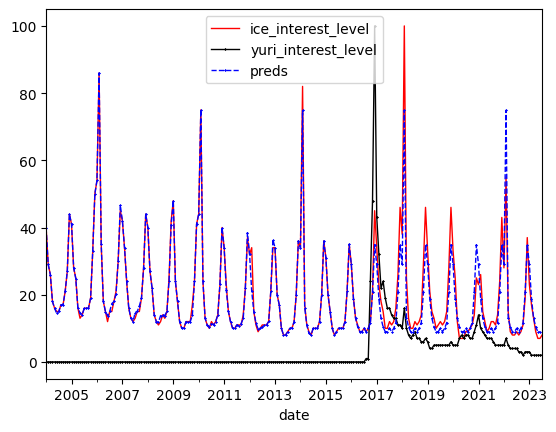

In [35]:
# line plot
fig, ax = plt.subplots()

result.plot.line(ax=ax, x = 'date', y = 'ice_interest_level', color = 'r', linewidth = 1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'yuri_interest_level', color = 'black', linewidth = 1,  marker = 'x', ms=1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'preds', color = 'b', linewidth = 1,  marker = 'x', ms=1, linestyle ='dashed')


Cross validation

In [36]:
x_cols = ['year', 'month', 'is_winter_olympics']
y_cols = ['ice_interest_level']
cat_cols = ['year', 'month', 'is_winter_olympics']
random_state = 1

X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg = buildDMatrix(ice_world_clean_df, 
                                                                             x_cols, y_cols, cat_cols, random_state)

Extracting feature and target arrays...
Done!
 ---
Casting categorical features as category object...
year                  category
month                 category
is_winter_olympics    category
dtype: object
Done!
 ---
Splitting the data into train and test...
Done!
 ---
Creating DMatrix regression matrices...
Done!


In [37]:
# Validation set
params = {"objective": "reg:squarederror"}
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 100

In [38]:
# Early stopping
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   # Activate early stopping
   early_stopping_rounds=10
)

[0]	train-rmse:18.72113	validation-rmse:17.35842
[10]	train-rmse:2.02773	validation-rmse:2.87762
[20]	train-rmse:0.70266	validation-rmse:2.56062
[28]	train-rmse:0.43910	validation-rmse:2.60457


In [39]:
# Evaluation
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 2.603


In [40]:
# Cross validation
results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

display(results.head())
best_rmse = results['test-rmse-mean'].min()
best_rmse

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,18.757614,0.704546,18.777436,3.494840
1,14.297623,0.523063,14.737953,3.691983
2,11.043020,0.346521,11.590855,3.770442
3,8.618672,0.235874,9.318742,3.484274
4,6.813510,0.158603,7.522477,3.305938


3.1434450278912665

### Breakdown by Country

In [42]:
# Create date features
ice_jp_df = getDateFeatures(ice_jp_df)

# Create Winter Olympics features
winter_olympics_df = pd.read_pickle("data/winter_olympics.pkl")  

ice_jp_df = pd.merge(ice_jp_df, winter_olympics_df, how="left", on="year")
ice_jp_df['is_winter_olympics'] = np.where((ice_jp_df['month'] == ice_jp_df['start_month']) |
(ice_jp_df['month'] == ice_jp_df['end_month']), True, False)

ice_jp_df[ice_jp_df['is_winter_olympics'] == True]

,date,ice_interest_level,isPartial,year,month,date_pairs,start_day,end_day,start_month,end_month,is_winter_olympics
25,2006-02-01,0,False,2006,2,"[10, 26]",10.0,26.0,2.0,2.0,True
73,2010-02-01,0,False,2010,2,"[12, 28]",12.0,28.0,2.0,2.0,True
121,2014-02-01,0,False,2014,2,"[7, 23]",7.0,23.0,2.0,2.0,True
169,2018-02-01,100,False,2018,2,"[9, 25]",9.0,25.0,2.0,2.0,True
217,2022-02-01,86,False,2022,2,"[4, 20]",4.0,20.0,2.0,2.0,True


In [325]:
# Clean dataset
ice_jp_clean_df = cleanDataset(ice_jp_df)
# Print some details of cleaned dataset
print("ice_jp_df rows:", len(ice_jp_df))
print("ice_jp_clean_df rows:", len(ice_jp_clean_df))
ice_jp_clean_df.sample(5)

ice_jp_df rows: 235
ice_jp_clean_df rows: 153


,date,ice_interest_level,isPartial,year,month,date_pairs,start_day,end_day,start_month,end_month,is_winter_olympics
87,2011-04-01,0,False,2011,4,NaN,NaN,NaN,NaN,NaN,False
34,2006-11-01,0,False,2006,11,"[10, 26]",10.0,26.0,2.0,2.0,False
73,2010-02-01,0,False,2010,2,"[12, 28]",12.0,28.0,2.0,2.0,True
84,2011-01-01,0,False,2011,1,NaN,NaN,NaN,NaN,NaN,False
6,2004-07-01,0,False,2004,7,NaN,NaN,NaN,NaN,NaN,False


In [326]:
# Build DMatrix
x_cols = ['year', 'month', 'is_winter_olympics']
y_cols = ['ice_interest_level']
cat_cols = ['year', 'month', 'is_winter_olympics']
random_state = 1

X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg = buildDMatrix(ice_jp_clean_df, 
                                                                             x_cols, y_cols, cat_cols, random_state)

Extracting feature and target arrays...
Done!
 ---
Casting categorical features as category object...
year                  category
month                 category
is_winter_olympics    category
dtype: object
Done!
 ---
Splitting the data into train and test...
Done!
 ---
Creating DMatrix regression matrices...
Done!


In [327]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}
n = 100

# Train model
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [328]:
# Evaluation
from sklearn.metrics import mean_squared_error
preds, rmse = getPredictions(model, dtest_reg, y_test, False)

RMSE of the base model: 0.000


In [330]:
# Get evaluation metrics dataframe
eval_cols = ['year', 'month']
x_cols = ['year', 'month']
target_col = 'ice_interest_level'
eval_df = getEvaluationMetrics(y_test, preds, eval_cols, x_cols, target_col)

In [332]:
result = pd.merge(ice_jp_df, eval_df[['year', 'month', 'preds']], how='left', on=['year', 'month'])

<Axes: xlabel='date'>

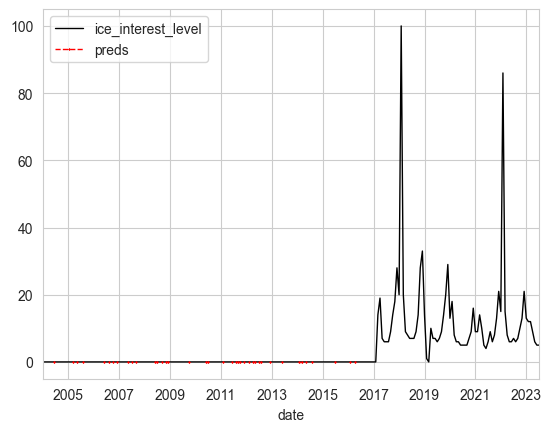

In [333]:
# line plot
fig, ax = plt.subplots()

result.plot.line(ax=ax, x = 'date', y = 'ice_interest_level', color = 'black', linewidth = 1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'preds', color = 'r', linewidth = 1,  marker = 'x', ms=1, linestyle ='dashed')

In [334]:
# Get prediction dataset to predict for interest levels without Yuri on Ice
ice_jp_prediction_df = cleanPredictionDataset(ice_jp_df)
# Print some details of cleaned dataset
print("ice_jp_df rows:", len(ice_jp_df))
print("ice_jp_prediction_df rows:", len(ice_jp_prediction_df))
ice_jp_prediction_df.sample(5)

ice_jp_df rows: 235
ice_jp_prediction_df rows: 234


,date,ice_interest_level,isPartial,year,month,date_pairs,start_day,end_day,start_month,end_month,is_winter_olympics
11,2004-12-01,0,False,2004,12,NaN,NaN,NaN,NaN,NaN,False
37,2007-02-01,0,False,2007,2,NaN,NaN,NaN,NaN,NaN,False
21,2005-10-01,0,False,2005,10,NaN,NaN,NaN,NaN,NaN,False
46,2007-11-01,0,False,2007,11,NaN,NaN,NaN,NaN,NaN,False
152,2016-09-01,0,False,2016,9,NaN,NaN,NaN,NaN,NaN,False


In [335]:
# Build DMatrix
x_cols = ['year', 'month', 'is_winter_olympics']
y_cols = ['ice_interest_level']
cat_cols = ['year', 'month', 'is_winter_olympics']
random_state = 1
test_size = 1.0

X, y, X_train, X_test, y_train, y_test, dtrain_reg, dtest_reg = buildDMatrix(ice_jp_prediction_df, 
                                                                             x_cols, y_cols, cat_cols, random_state,
                                                                             test_size)

Extracting feature and target arrays...
Done!
 ---
Casting categorical features as category object...
year                  category
month                 category
is_winter_olympics    category
dtype: object
Done!
 ---
Splitting the data into train and test...
Done!
 ---
Creating DMatrix regression matrices...
Done!


In [336]:
# Get predictions
preds, rmse = getPredictions(model, dtest_reg, y_test, False)

RMSE of the base model: 11.172


In [341]:
eval_cols = ['year', 'month']
x_cols = ['year', 'month']
target_col = 'ice_interest_level'
eval_df = getEvaluationMetrics(y, preds, eval_cols, x_cols, target_col)

In [343]:
result = pd.merge(ice_jp_df, eval_df[['year', 'month', 'preds']], how='left', on=['year', 'month'])
# Merge with Yuri on Ice
result = pd.merge(result, yuri_world_df[['date', 'yuri_interest_level']], how='left', on=['date'])
result

,date,ice_interest_level,isPartial,year,month,date_pairs,start_day,end_day,start_month,end_month,is_winter_olympics,preds,yuri_interest_level
0,2004-01-01,0,False,2004,1,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,0
1,2004-02-01,0,False,2004,2,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,0
2,2004-03-01,0,False,2004,3,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,0
3,2004-04-01,0,False,2004,4,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,0
4,2004-05-01,0,False,2004,5,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2023-03-01,12,False,2023,3,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,2
231,2023-04-01,9,False,2023,4,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,2
232,2023-05-01,6,False,2023,5,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,2
233,2023-06-01,5,False,2023,6,NaN,NaN,NaN,NaN,NaN,False,2.345963e-16,2


<Axes: xlabel='date'>

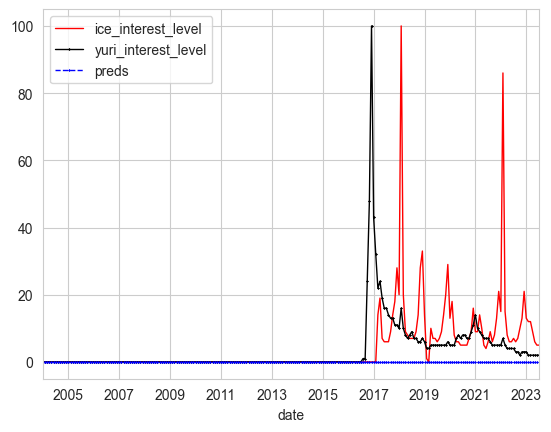

In [344]:
# line plot
fig, ax = plt.subplots()

result.plot.line(ax=ax, x = 'date', y = 'ice_interest_level', color = 'r', linewidth = 1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'yuri_interest_level', color = 'black', linewidth = 1,  marker = 'x', ms=1, linestyle ='solid')
result.plot.line(ax=ax, x = 'date', y = 'preds', color = 'b', linewidth = 1,  marker = 'x', ms=1, linestyle ='dashed')

#### Validation

Check against GoogleTrends

<Axes: >

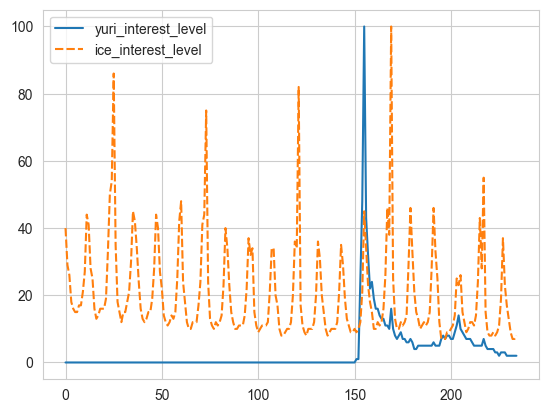

In [285]:
result = pd.concat([yuri_world_df, ice_world_df], axis=1, join="inner")

# Plotting
sns.color_palette("mako", as_cmap=True)
sns.set_style("whitegrid")
sns.lineplot(
    data=result[['yuri_interest_level', 'ice_interest_level']]
)

### ARCHIVE

Get daily data

In [15]:
# # Get list of years
# yuri_years_lst = getYears(yuri_world_df)
# # Get date dataframe for calling Google Trends API
# ym_yuri_df = getDates(yuri_years_lst)
# # Test out getting daily data from Google Trends API
# yuri_topic_id, yuri_world_daily_df = getInterestOverTime(["Yuri on Ice"], "Japanese animated series", '2016-01-01 2016-02-01')

# # Display if debugging
# if parameters["debug"]:
#     print("yuri_years_lst:")
#     print(yuri_years_lst)

#     print("ym_yuri_df:")
#     display(ym_yuri_df)

#     print("yuri_world_daily_df")
#     display(yuri_world_daily_df)